In [1]:
!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties

In [2]:
# initialize Spark

import matplotlib.pyplot as plt
import pandas as pd
import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import pyspark.sql.functions as F

import os

conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'PySpark DataFrame Demo')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

print (spark.version, pyspark.version.__version__)

2023-05-23 01:33:59,385 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


3.3.1 3.3.1


In [3]:
df = spark.read.csv('file:///home/work/project/mas-dse-230/Crimes_-_2001_to_Present.csv', header=True)

1. data cleaning
2. features used
3. train/validation/test sets
4. analysis approach
    <br>a. input: cleaned, filtered training data
    <br>b. setup: create model, cross-validate for hyperparameters
    <br>c. output: final model, predictions, scores
5. challenges encountered
6. post-model analysis, discussion of results

In [4]:
df.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location',
 'Historical Wards 2003-2015',
 'Zip Codes',
 'Community Areas',
 'Census Tracts',
 'Wards',
 'Boundaries - ZIP Codes',
 'Police Districts',
 'Police Beats']

In [5]:
from pyspark.sql.functions import regexp_replace

new_cats = {'CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT','NON-CRIMINAL (SUBJECT SPECIFIED)':'NON-CRIMINAL', 'NON - CRIMINAL':'NON-CRIMINAL',
            'OTHER NARCOTIC VIOLATION':'NARCOTICS','PUBLIC INDECENCY':'PUBLIC INDECENCY/OBSCENITY', 'OBSCENITY':'PUBLIC INDECENCY/OBSCENITY'}

for i in new_cats:
    df = df.replace(i,new_cats[i],"Primary Type")

In [6]:
## Drop NAs

In [7]:
df.select([count(when(col(c).isNotNull(), c)).alias(c) for c in df.columns]).toPandas()

2023-05-23 01:34:09,267 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,7776558,7776554,7776558,7776558,7776558,7776558,7776558,7766233,7776558,7776558,...,7690048,7690048,7667355,7690048,7670452,7672588,7670569,7670504,7671621,7671644


In [8]:
# Count number of NAs for each Year to see if there is any correlation between NA values and year
columns = pd.Series(df.columns)
columns = columns[columns != 'Year']
before_year_na = df.groupBy('Year').count().toPandas()
df2 = df.dropna()
after_year_na = df2.groupBy('Year').count().toPandas()
after_year_na.columns = ['Year', 'count_after']
final_na_counts = before_year_na.merge(after_year_na, on='Year')
final_na_counts['prop_kept'] = final_na_counts['count_after'] / final_na_counts['count']
final_na_counts = final_na_counts.sort_values(by='Year')
final_na_counts

,Year,count,count_after,prop_kept
20,2001,485878,3885,0.007996
8,2002,486802,343581,0.705792
22,2003,475979,469978,0.987392
12,2004,469421,465257,0.991129
7,2005,453771,448002,0.987287
11,2006,448174,443609,0.989814
16,2007,437084,433874,0.992656
15,2008,427165,418048,0.978657
10,2009,392819,384159,0.977954
21,2010,370496,368307,0.994092


In [9]:
df_final = df2.select('Date', 'Primary Type', 'Description', 'Location Description', 'Domestic', 'Beat', 'District',
                      'Ward', 'Zip Codes', 'Arrest')
df_final = df_final.where('Year > 2002 AND Year < 2023')
df_final.show()

+--------------------+---------------+--------------------+--------------------+--------+----+--------+----+---------+------+
|                Date|   Primary Type|         Description|Location Description|Domestic|Beat|District|Ward|Zip Codes|Arrest|
+--------------------+---------------+--------------------+--------------------+--------+----+--------+----+---------+------+
|09/05/2015 01:30:...|        BATTERY|DOMESTIC BATTERY ...|           RESIDENCE|    true|0924|     009|  12|    14924| false|
|09/04/2015 11:30:...|          THEFT|      POCKET-PICKING|             CTA BUS|   false|1511|     015|  29|     4299| false|
|09/05/2015 12:45:...|      NARCOTICS|POSS: HEROIN(BRN/...|            SIDEWALK|   false|1412|     014|  35|    21538|  true|
|09/05/2015 01:00:...|        ASSAULT|              SIMPLE|           APARTMENT|    true|1522|     015|  28|    22216| false|
|09/05/2015 10:55:...|       BURGLARY|      FORCIBLE ENTRY|           RESIDENCE|   false|0614|     006|  21|    21554|

In [10]:
df_length = df_final.count()
df_length

6634690

In [11]:
df_final.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Zip Codes: string (nullable = true)
 |-- Arrest: string (nullable = true)



## Make Month column

<Axes: xlabel='Month'>

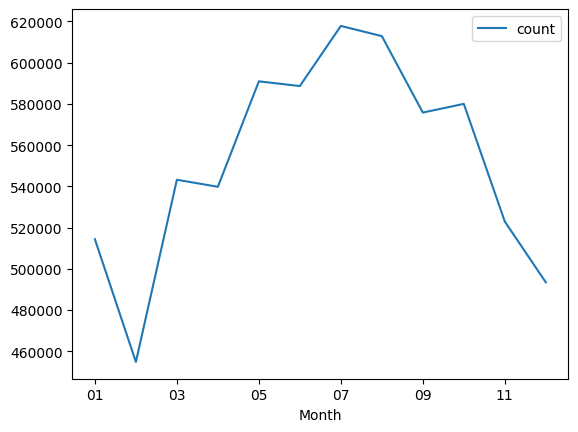

In [12]:
df_final = df_final.withColumn('Month', substring('Date', 0, 2))
df_final.groupBy('Month').count().toPandas().sort_values('Month').plot(x='Month', y='count')

## Make Hour column

In [13]:
df_final = df_final.withColumn('Hour', from_unixtime(unix_timestamp('Date','MM/dd/yyyy hh:mm:ss a'),'HH'))

In [14]:
df_final.groupBy('Location Description').count().orderBy('count', ascending=False).show(10)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1694154|
|           RESIDENCE|1088378|
|           APARTMENT| 788073|
|            SIDEWALK| 656854|
|               OTHER| 223114|
|PARKING LOT/GARAG...| 169235|
|               ALLEY| 148224|
|  SMALL RETAIL STORE| 127646|
|SCHOOL, PUBLIC, B...| 124179|
|    RESIDENCE-GARAGE| 114583|
+--------------------+-------+
only showing top 10 rows



<Axes: xlabel='Month'>

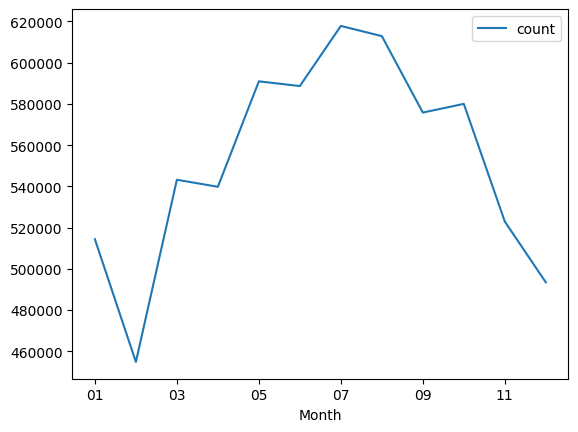

In [15]:
df_final = df_final.withColumn('Hour', substring('Date', 0, 2))
df_final.groupBy('Month').count().toPandas().sort_values('Month').plot(x='Month', y='count')

In [16]:
print(df_final.select('Description').distinct().count())
mappings = {
    'AGGRAVATED':'AGG',
    'ATTEMPT':'ATT',
    'CRIMINAL':'CRIM',
    'POSSESSION':'POSS',
    'POS ':'POSS',
    'POSESS:':'POSS ',
    'POSESS ':'POSS ',    
    'REGISTRATION':'REG',
    'PRO. ':'PROFESSIONAL ',
    'PO ': 'POLICE OFFICER ',
    'P.O.':'POLICE OFFICER',
    'RITUAL': 'RIT',
    'MUTILATION':'MUT',
    'INSTRUMENT':'INSTR',
    'MANU/DEL:':'MANUFACTURE DELIVER',
    'MANU/DELIVER:':'MANUFACTURE DELIVER',
    'MANUFACTURE / DELIVER':'MANUFACTURE DELIVER'
}
replacement_expr = col('Description')
for k, v in mappings.items():
    replacement_expr = regexp_replace(replacement_expr, k, v)
df_final = df_final.withColumn('Description', replacement_expr)
df_final = df_final.withColumn('Description', regexp_replace(df_final['Description'], '[^A-Za-z0-9]', ''))
print(df_final.select('Description').distinct().count())

538


466


In [19]:
X = df_final.select('Primary Type', 'Location Description', 'Ward')
y = df_final.select('Arrest')
X.show(10)
y.show(10)

+------------+--------------------+----+
|Primary Type|Location Description|Ward|
+------------+--------------------+----+
|     BATTERY|           RESIDENCE|  12|
|       THEFT|             CTA BUS|  29|
|   NARCOTICS|            SIDEWALK|  35|
|     ASSAULT|           APARTMENT|  28|
|    BURGLARY|           RESIDENCE|  21|
|    BURGLARY|    RESIDENCE-GARAGE|  32|
|       THEFT|  GROCERY FOOD STORE|  25|
|     ROBBERY|              STREET|  27|
|       THEFT|PARKING LOT/GARAG...|  13|
|     BATTERY|  SMALL RETAIL STORE|  45|
+------------+--------------------+----+
only showing top 10 rows

+------+
|Arrest|
+------+
| false|
| false|
|  true|
| false|
| false|
| false|
|  true|
| false|
| false|
| false|
+------+
only showing top 10 rows



In [20]:
# From https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.TrainValidationSplit.html
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel
import tempfile
# Feature Preparation
primaryTypeIndexer = StringIndexer(inputCol='Primary Type', outputCol='primTypeIdx')
locationIndexer = StringIndexer(inputCol='Location Description', outputCol='locDescIdx')
wardIndexer = StringIndexer(inputCol='Ward', outputCol='wardIdx')
#Fits a model to the input dataset with optional parameters.
df1 = primaryTypeIndexer.fit(df_final).transform(df_final)
df2 = locationIndexer.fit(df1).transform(df1)
df3 = wardIndexer.fit(df2).transform(df2)
oneHotEnc = OneHotEncoder(inputCol=, outputCol="qualification_vec")
df11 = onehotencoder_qualification_vector.fit(df1).transform(df1)
df_final.show()
# Models
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
evaluator = BinaryClassificationEvaluator()
# Logistic Regressor
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
lr_tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=1, seed=42)
lr_tvs_model = lr_tvs.fit(df3)
print(lr_tvs_model.getTrainRatio())
model_path = 'file:///home/work/project/models/logreg'
lr_tvs_model.write().save(model_path)
# Decision Tree
# grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
# dt_tvs = TrainValidationSplit(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator,
#     parallelism=1, seed=42)
# tvsModel = tvs.fit(dataset)

# evaluator.evaluate(tvsModel.transform(dataset))

# evaluator.evaluate(tvsModelRead.transform(dataset))


NameError: name 'dataset' is not defined